In [1068]:
# import autograd.numpy as np
import numpy as np
from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent
from geomstats.geometry.hypersphere import Hypersphere
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geomstats.backend as gs

# gs.random.seed(2020)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)

# Setting up the Hypersphere

In [1069]:
# Sampling Hypersphere
n_samples=1000
dim = 2
sphere = Hypersphere(dim=dim)
points_in_manifold = sphere.random_uniform(n_samples)

In [1070]:
# Creating Initial Point and Tangent Vector
x_0 = points_in_manifold[0,:]
vector = gs.array([1, 0, 1])
tangent_vector = sphere.to_tangent(vector, base_point=x_0)

print(f'Starting Point on manifold: {x_0}')
print(f'Tangent Vector: {tangent_vector}')

Starting Point on manifold: [-0.41220215 -0.43377711 -0.80120335]
Tangent Vector: [ 0.49983164 -0.52634753  0.02781545]


In [1071]:
# Wireframe for Sphere Surface
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

#https://stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector-in-matplotlib

Text(0.5, 0.92, 'Hypersphere of Dimension 3')

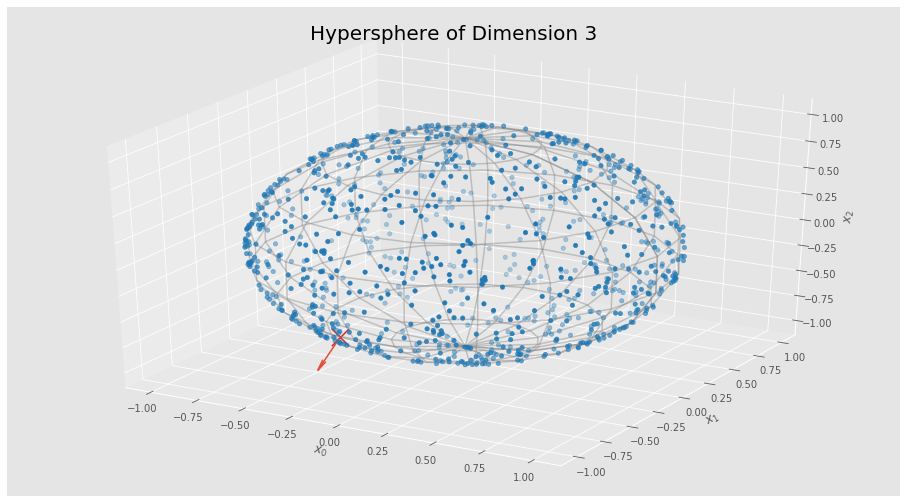

In [1072]:
# Plotting Points in 3D
ax = plt.axes(projection='3d')

# Points with first one Highlighted
ax.scatter(points_in_manifold[1:,0],points_in_manifold[1:,1],points_in_manifold[1:,2],color="tab:blue",s=20)
ax.scatter(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],color="tab:red",s=300, marker="x")

# Tangent Vector
ax.quiver(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],
          points_in_manifold[0,0] + tangent_vector[0],points_in_manifold[0,1] + tangent_vector[1],points_in_manifold[0,2] + 
          tangent_vector[2], length=0.25)
# Sphere
ax.plot_wireframe(x, y, z, color="grey", alpha=0.4)
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.set_zlabel(r'$x_2$')
ax.set_title(f'Hypersphere of Dimension {dim + 1}', fontsize=20)

In [1073]:
def sphere_exp_map(v, x):
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    ans = x * np.cos(np.linalg.norm(v)/r) + (r*v/np.linalg.norm(v))*np.sin(np.linalg.norm(v)/r)
    return ans

def sphere_R_map(v, x):
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    num = x + v
    denom = np.linalg.norm(x + v)
    return r * (num / denom)

# https://wiseodd.github.io/techblog/2019/02/22/optimization-riemannian-manifolds/

In [1074]:
# Testing Exponential Mapping
x_manifold = sphere_exp_map(tangent_vector, x_0)
x_manifold_geomstats = sphere.metric.exp(tangent_vector, base_point=x_0)

# https://geomstats.github.io/notebooks/02_from_vector_spaces_to_manifolds.html

In [1075]:
print(f'Point from our Function: {x_manifold}\nPoint from GeomStats: {x_manifold_geomstats}')

Point from our Function: [ 0.1488691  -0.80554669 -0.57352638]
Point from GeomStats: [ 0.1488691  -0.80554669 -0.57352638]


In [1076]:
# Testing Retraction Mapping
x_manifold_R = sphere_R_map(tangent_vector, x_0)
x_manifold_geomstats_R = sphere.metric.exp(tangent_vector, base_point=x_0)

In [1077]:
x_manifold_R
# Not sure if geomstats has an option for retraction built in for sphere...

array([ 0.07089878, -0.77681231, -0.62572838])

# First Order Optimization Methods

## Riemanian Gradient Descent

In [1078]:
def RGD(x, lam, GradR, GradRet, f=None, tol=1e-7, max_iter=1e4):
    """
    Input: x (starting point on manifold), lam (step size) IMPLEMENT LINE SEARCH VARIANTS TOO, f (cost function), algo (1 = Retraction, 0 = Exponential Mapping)
    Output: Point on manifold that minimizes cost function
    """
    err = []
    x_prev = x
    if f != None:
        for i in range(int(max_iter)):
        
            r_grad = GradR(x) # riemannian gradient
            lam = linesearch(x, f, GradRet, GradR)
            x = GradRet(-lam*r_grad, x) # riemannian descent
            
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            err.append(error)
            if error < tol: # stopping criteria
                return x, err
            x_prev = x
            
        print(f'Reached max iterations.')
        return x, err
    else:

        for i in range(int(max_iter)):
            
            r_grad = GradR(x) # riemannian gradient
            x = GradRet(-lam*r_grad, x) # riemannian descent
            
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            err.append(error)
            if error < tol: # stopping criteria
                return x, err
            x_prev = x
        
        print(f'Reached max iterations.')
        return x, err

def SphereRGrad(x, u):
    I = np.identity(len(x))
    return (I - x * x.T) @ u(x)

def linesearch(x, f, GradRet, GradR):
    r = 1e-4
    tau = 0.8
    t = 1
    while (f(x) - f(GradRet(-t * GradR(x), x))) < r * t * np.linalg.norm(GradR(x))**2:
        t = tau * t
    return t

In [1079]:
# Define hypershphere dimension and A matrix for cost function
dim = 10
A = np.random.rand(dim,dim)
# A = 1/2*(A + A.T)
A = A.T @ A

# Define cost function, euclidean gradient of cost, and riemannian gradient
f = lambda x: 0.5*x.T @ A @ x
df = lambda x: A @ x
gradR = lambda x: SphereRGrad(x, df)

In [1080]:
# Costant Learning Rate and inital value
lam = 0.05
x_0 = np.random.rand(dim,1)

# Running RGD on variants
x_optimal = RGD(x_0, lam, gradR, sphere_R_map, f=None)
x_optimal_ls = RGD(x_0, lam, gradR, sphere_R_map, f=f)
x_optimal_eucl = RGD(x_0, lam, df, sphere_R_map, f=None)
x_optimal_eucl_ls = RGD(x_0, lam, df, sphere_R_map, f=f)

# Results
print(f'Optimal Value is {x_optimal[0]}\n achieved in {len(x_optimal[1])} iterations.')
print(f'Optimal Value is {x_optimal_ls[0]}\n achieved in {len(x_optimal_ls[1])} iterations.')
print(f'Optimal Value is {x_optimal_eucl[0]}\n achieved in {len(x_optimal_eucl[1])} iterations.')
print(f'Optimal Value is {x_optimal_eucl_ls[0]}\n achieved in {len(x_optimal_eucl_ls[1])} iterations.')

Reached max iterations.
Reached max iterations.
Optimal Value is [[ 0.03214454]
 [ 0.03894284]
 [ 0.37356709]
 [ 0.3566029 ]
 [-0.04233921]
 [-0.32777359]
 [-0.03848679]
 [-0.25288918]
 [-0.51452594]
 [ 0.53975267]]
 achieved in 10000 iterations.
Optimal Value is [[ 0.03214734]
 [ 0.03905057]
 [ 0.373565  ]
 [ 0.35667298]
 [-0.04250016]
 [-0.32778982]
 [-0.03844257]
 [-0.25297593]
 [-0.51443005]
 [ 0.53973125]]
 achieved in 9449 iterations.
Optimal Value is [[ 0.03214455]
 [ 0.03894309]
 [ 0.37356708]
 [ 0.35660306]
 [-0.04233958]
 [-0.32777362]
 [-0.03848668]
 [-0.25288938]
 [-0.51452572]
 [ 0.53975262]]
 achieved in 10000 iterations.
Optimal Value is [[ 0.03191365]
 [ 0.03600061]
 [ 0.37352492]
 [ 0.35468489]
 [-0.03801147]
 [-0.32683458]
 [-0.03985626]
 [-0.25079838]
 [-0.51720901]
 [ 0.54046648]]
 achieved in 1195 iterations.


## Eigenvalue Checking for Specific Cost Function

In [1081]:
# Eigenvalues, eigenvectors = ...
u, v = np.linalg.eigh(A)

In [1082]:
print(f'Eigenvalues: {u}')
idx = np.argmin(u)
print(f'Minimum eigenvalue\'s eigenvector: {v[:,idx]}')

# Optimal Value of Objective Function (corresponds to the minimum eigenvalue)
f(x_optimal[0])*2

Eigenvalues: [6.96079736e-03 1.44683651e-02 7.68874948e-02 2.51897307e-01
 5.45004332e-01 7.84966319e-01 1.02094981e+00 1.30545614e+00
 2.59975437e+00 2.73525890e+01]
Minimum eigenvalue's eigenvector: [ 0.03214815  0.03908215  0.37356436  0.35669352 -0.04254739 -0.3277946
 -0.03842962 -0.25300139 -0.51440194  0.53972494]


array([[0.0069608]])

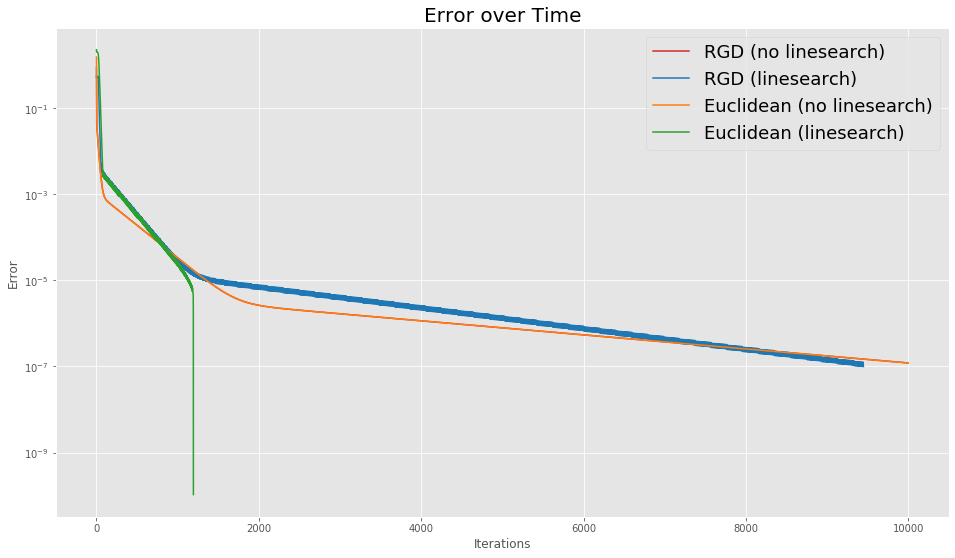

In [1083]:
# Plotting local error over time
plt.plot(x_optimal[1], color='tab:red', label='RGD (no linesearch)')
plt.plot(x_optimal_ls[1], color='tab:blue', label='RGD (linesearch)')
plt.plot(x_optimal_eucl[1], color='tab:orange', label='Euclidean (no linesearch)')
plt.plot(x_optimal_eucl_ls[1], color='tab:green', label='Euclidean (linesearch)')
plt.title('Error over Time', fontsize=20)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.yscale('log')
plt.legend(fontsize=18)

## Comparing to PyManOpt

In [1084]:
# Importing Packages
import autograd.numpy as np
from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

In [1085]:
# (1) Instantiate a manifold
manifold = Sphere(dim)

# (2) Setup Problem
problem = Problem(manifold=manifold, cost=f)

# (3) Instantiate a Pymanopt solver
solver = SteepestDescent()

# let Pymanopt do the rest
Xopt = solver.solve(problem)
print(Xopt)

e-03	4.68010456e-03
  561	+6.9426535081848059e-03	2.11462031e-03
  562	+6.9411478300083571e-03	5.05326210e-03
  563	+6.9406510350664341e-03	3.50133319e-03
  564	+6.9403713492391271e-03	4.00775586e-03
  565	+6.9400319013207465e-03	3.73086288e-03
  566	+6.9399237140207711e-03	5.56835944e-03
  567	+6.9395620359933288e-03	3.81098243e-03
  568	+6.9394999528305402e-03	5.88503042e-03
  569	+6.9392729258409046e-03	4.89009282e-03
  570	+6.9387511037468227e-03	2.08487402e-03
  571	+6.9367524844979782e-03	2.92177160e-03
  572	+6.9365409476518439e-03	4.96956814e-03
  573	+6.9360215333953363e-03	2.10151908e-03
  574	+6.9341894032015532e-03	3.97968696e-03
  575	+6.9337987513598829e-03	2.86912870e-03
  576	+6.9334954199422403e-03	3.77173683e-03
  577	+6.9332638021488710e-03	4.67599838e-03
  578	+6.9327670486315713e-03	2.18992604e-03
  579	+6.9318097477798282e-03	7.15739699e-03
  580	+6.9315593153507059e-03	7.44291397e-03
  581	+6.9307856508393243e-03	4.17347758e-03
  582	+6.9306455749041226e-03	5.567

In [1086]:
print(f'PyManOpt: {Xopt}')
print(f'Ours: {x_optimal[0]}')
np.linalg.norm(x_optimal[0] - Xopt) / np.linalg.norm(Xopt)

PyManOpt: [-0.02274408 -0.41542997 -0.13456422 -0.39643607  0.61462678  0.18550987
 -0.14986868  0.41874222 -0.16065587 -0.12583954]
Ours: [[ 0.03214454]
 [ 0.03894284]
 [ 0.37356709]
 [ 0.3566029 ]
 [-0.04233921]
 [-0.32777359]
 [-0.03848679]
 [-0.25288918]
 [-0.51452594]
 [ 0.53975267]]


4.479017292877851

It seems that with our usual cost function, RGD works but R-newton does not (because A is not positive definite); however, when we choose A to be positive definite, we get varying results from RGD and our newton method sometimes matches RGD. This tells me, I should check into more about the assumptions and numerical stabilties of these methods.

# Second Order Optimization Methods

## Riemannian Newton's Method

In [1087]:
def RNM(x, gradR, gradRet, Hess_f, tol=1e-7, max_iter=1e4):
    x_prev = x
    err = []
    for i in range(int(max_iter)):
        s_k = np.linalg.inv(Hess_f(x)) @ - gradR(x)
        x = gradRet(s_k, x)

        error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
        err.append(error)
        if error < tol: # stopping criteria
            return x, err
        x_prev = x

    print('Reached Max Iterations...')
    return x, err
def Hess_f(x):
    return A

In [1088]:
# Running Riemannan Newton's Method
x_optimal_newton = RNM(x_0, gradR, sphere_R_map, Hess_f)

In [1089]:
print(f'Optimal Value is {x_optimal_newton[0]}\n achieved in {len(x_optimal_newton[1])} iterations.')

Optimal Value is [[ 0.03214815]
 [ 0.03908213]
 [ 0.37356436]
 [ 0.35669351]
 [-0.04254736]
 [-0.32779459]
 [-0.03842963]
 [-0.25300137]
 [-0.51440196]
 [ 0.53972495]]
 achieved in 17 iterations.


In [1090]:
np.linalg.norm(x_optimal_newton[0] - Xopt) / np.linalg.norm(Xopt)

4.479019078315297

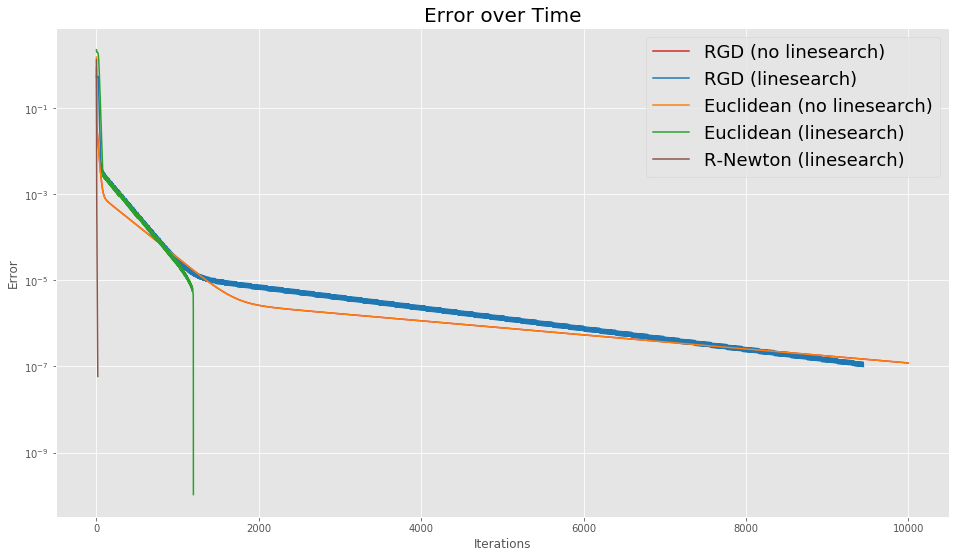

In [1091]:
# Plotting local error over time
plt.plot(x_optimal[1], color='tab:red', label='RGD (no linesearch)')
plt.plot(x_optimal_ls[1], color='tab:blue', label='RGD (linesearch)')
plt.plot(x_optimal_eucl[1], color='tab:orange', label='Euclidean (no linesearch)')
plt.plot(x_optimal_eucl_ls[1], color='tab:green', label='Euclidean (linesearch)')
plt.plot(x_optimal_newton[1], color='tab:brown', label='R-Newton (linesearch)')
plt.title('Error over Time', fontsize=20)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.yscale('log')
plt.legend(fontsize=18)